# Data Cleaning Listado de Listado de Beneficiarios 2019-2022

## Autores
- José Luis Delgado Dávara
- Arturo Ortiz Aguilar
- Beltrán Valle Gutiérrez-Cortines

## Importante leer para entender

En este Notebook se trabaja con 3 listados importantes:

1. Beneficiarios2019_2022 -> Dataset con el listado de TODOS los beneficiarios.
2. Estados_Beneficiarios_2019_2022 -> Dataset sólo con los estados *únicos* encontrados en el dataset anterior.
3. Diccionario -> Emparejamiento entre ambos listados de beneficiarios
4. Dataset_Inegi -> Catálogo obtenido de Inegi

In [1]:
import pandas as pd
import seaborn as sns
from thefuzz import fuzz
from thefuzz import process
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import re
import unidecode

In [2]:
def load_datasets(directory):
    # Get a list of all CSV files in the directory
    csv_files = glob.glob(os.path.join(directory, '*.csv'))

    # Read each CSV file and store the DataFrame in a list
    dataframes = [pd.read_csv(file, encoding='utf-8', skiprows=0) for file in csv_files]

    # Print the number of rows for each DataFrame
    for i, df in enumerate(dataframes):
        print(f"Number of rows in DataFrame {i+1}: {df.shape[0]}")

    # Calculate the sum of rows in each individual dataset
    individual_row_sum = sum([df.shape[0] for df in dataframes])

    # Concatenate all DataFrames in the list
    merged_df = pd.concat(dataframes, join='inner', ignore_index=True)

    return merged_df, individual_row_sum


def clean_text(text):
    """
    De esta manera tenemos el texto sin espacios blancos extra y sobre todo con todas las palabras con capitalización correcta.
    """
    if pd.isna(text):
        return text
    text = text.strip()  # Eliminate white spaces
    text = text.lower()  # Convert to lowercase
    text = unidecode.unidecode(text)  # Remove accents
    text = re.sub('-.*-', '', text) #Remove what is in between - -
    text = re.sub('\s+', ' ', text)  # Eliminate extra white spaces
    text = re.sub('^\s+|\s+?$', '', text)  # Eliminate spaces at the beginning and end
    return text

# 1. Lectura y limpieza de datos

### 1.1 Beneficiarios 2019-2022

Obtenemos el listado único de localidades y listado único de municipios con sus claves.

In [36]:
listado_beneficiarios, sumOfRows = load_datasets("../../data/productores_beneficiarios 2019-2022")

Number of rows in DataFrame 1: 826385
Number of rows in DataFrame 2: 394986
Number of rows in DataFrame 3: 369124
Number of rows in DataFrame 4: 278550


In [40]:
print(f"Columnas: {listado_beneficiarios.columns}")
listado_beneficiarios.head()

Columnas: Index(['BENEFICIARIO', 'ZONA', 'ENTIDAD', 'MUNICIPIO', 'LOCALIDAD',
       'ESTRATIFICACIÓN', 'PROGRAMA', 'COMPONENTE', 'SUBCOMPONENTE',
       'PRODUCTO', 'FECHA', 'MONTO FEDERAL', 'APOYO', 'ACTIVIDAD', 'ESLABÓN',
       'CICLO AGRÍCOLA'],
      dtype='object')


,BENEFICIARIO,ZONA,ENTIDAD,MUNICIPIO,LOCALIDAD,ESTRATIFICACIÓN,PROGRAMA,COMPONENTE,SUBCOMPONENTE,PRODUCTO,FECHA,MONTO FEDERAL,APOYO,ACTIVIDAD,ESLABÓN,CICLO AGRÍCOLA
0,ABAC NERI JESUS CARLOS,CENTRO PAÍS,GUERRERO,COYUCA DE BENÍTEZ,PUEBLO VIEJO,Alto,FERTILIZANTES,FERTILIZANTES,FERTILIZANTES,Cultivo de maíz grano blanco,2022-06-26,12244.18,Fertilizantes,AGRARIA,AGRARIA,PV2022
1,ABAD ALARCON ELIAZAR,CENTRO PAÍS,GUERRERO,COYUCA DE BENÍTEZ,PUEBLO VIEJO,Alto,FERTILIZANTES,FERTILIZANTES,FERTILIZANTES,Cultivo de maíz grano blanco,2022-06-26,6122.09,Fertilizantes,AGRARIA,AGRARIA,PV2022
2,ABAD ALARCON EZEQUIEL,CENTRO PAÍS,GUERRERO,COYUCA DE BENÍTEZ,AGUA ZARCA,Alto,FERTILIZANTES,FERTILIZANTES,FERTILIZANTES,Cultivo de maíz grano blanco,2022-07-12,12244.18,Fertilizantes,AGRARIA,AGRARIA,PV2022
3,ABAD ALARCON FULGENCIO,CENTRO PAÍS,GUERRERO,COYUCA DE BENÍTEZ,AGUA ZARCA,Alto,FERTILIZANTES,FERTILIZANTES,FERTILIZANTES,Cultivo de maíz grano blanco,2022-07-12,12244.18,Fertilizantes,AGRARIA,AGRARIA,PV2022
4,ABAD ALARCON ROMALDA,CENTRO PAÍS,GUERRERO,COYUCA DE BENÍTEZ,YERBASANTITA,Alto,FERTILIZANTES,FERTILIZANTES,FERTILIZANTES,Cultivo de maíz grano blanco,2022-06-20,12244.18,Fertilizantes,AGRARIA,AGRARIA,PV2022


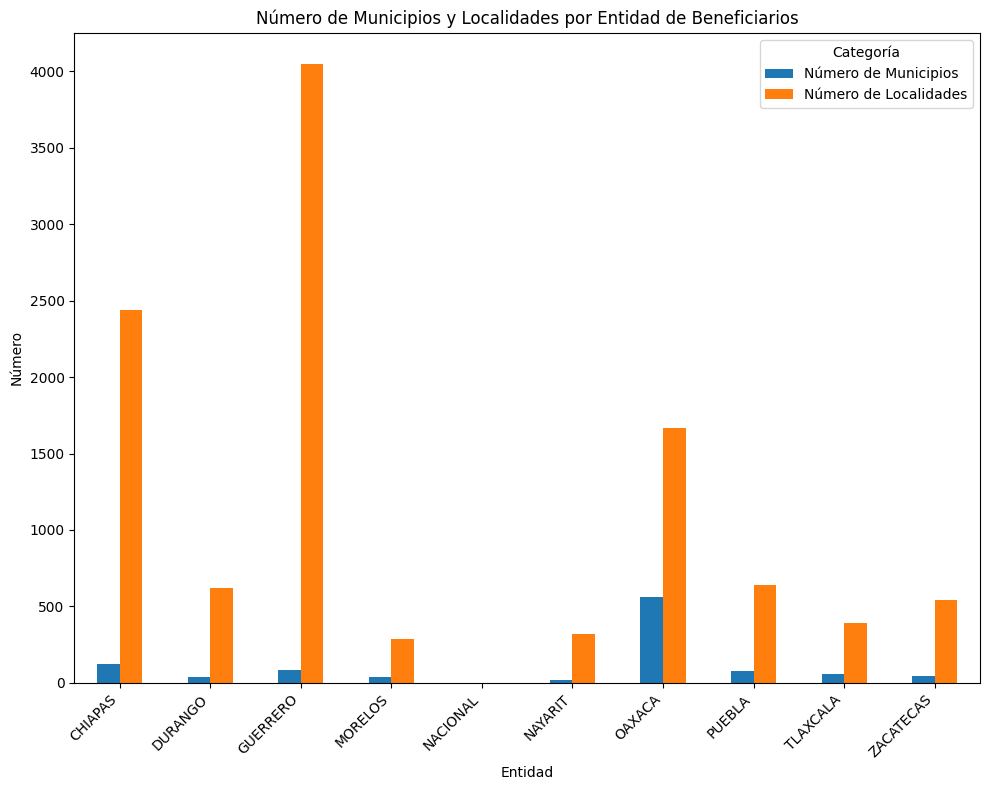

In [41]:
agrupado = listado_beneficiarios.groupby('ENTIDAD').agg({'MUNICIPIO': pd.Series.nunique, 'LOCALIDAD': pd.Series.nunique}).reset_index()

# Renombrar columnas para claridad
agrupado.columns = ['Entidad', 'Número de Municipios', 'Número de Localidades']

# Graficar
fig, ax = plt.subplots(figsize=(10, 8))
agrupado.plot(kind='bar', x='Entidad', y=['Número de Municipios', 'Número de Localidades'], ax=ax)
plt.title('Número de Municipios y Localidades por Entidad de Beneficiarios')
plt.xlabel('Entidad')
plt.ylabel('Número')
plt.xticks(rotation=45, ha="right")
plt.legend(title='Categoría')
plt.tight_layout()

plt.show()

In [43]:
# Obtenemos las localidades únicas en el dataset.
Localidades_19_22 = listado_beneficiarios[['ENTIDAD', 'MUNICIPIO', 'LOCALIDAD']]
Localidades_19_22 = Localidades_19_22.drop_duplicates()

# Estandarizamos la limpieza de los datos
Localidades_19_22['ENTIDAD_c_benef'] = Localidades_19_22['ENTIDAD'].apply(clean_text)
Localidades_19_22['MUNICIPIO_c_benef'] = Localidades_19_22['MUNICIPIO'].apply(clean_text)
Localidades_19_22['LOCALIDAD_c_benef'] = Localidades_19_22['LOCALIDAD'].apply(clean_text)

# Creamos las dos keys de beneficiarios 
Localidades_19_22['KEY_benef_mun'] = Localidades_19_22['ENTIDAD_c_benef'].astype(str) + '-' + Localidades_19_22[
    'MUNICIPIO_c_benef'].astype(str)

Localidades_19_22['KEY_benef_loc'] = Localidades_19_22['ENTIDAD_c_benef'].astype(str) + '-' + Localidades_19_22[
    'MUNICIPIO_c_benef'].astype(str) + '-' + Localidades_19_22['LOCALIDAD_c_benef'].astype(str)

Localidades_19_22.shape

(13220, 8)

In [ ]:
# Valores únicos y la cantidad de cada columna
# Obtener estadísticas descriptivas para todas las variables

descriptive_stats = Localidades_19_22.describe(include='all').transpose()

# Mostrar las estadísticas descriptivas
print(descriptive_stats)

In [46]:
# Obtenemos las localidades únicas en el dataset.
Municipios_19_22 = listado_beneficiarios[['ENTIDAD', 'MUNICIPIO']]
Municipios_19_22 = Municipios_19_22.drop_duplicates()

# Estandarizamos la limpieza de los datos
Municipios_19_22['ENTIDAD_c_benef'] = Municipios_19_22['ENTIDAD'].apply(clean_text)
Municipios_19_22['MUNICIPIO_c_benef'] = Municipios_19_22['MUNICIPIO'].apply(clean_text)

# Creamos las dos keys de beneficiarios 
Municipios_19_22['KEY_benef_mun'] = Municipios_19_22['ENTIDAD_c_benef'].astype(str) + '-' + Municipios_19_22[
    'MUNICIPIO_c_benef'].astype(str)

Municipios_19_22.shape

(1034, 5)

In [ ]:
# Valores únicos y la cantidad de cada columna
# Obtener estadísticas descriptivas para todas las variables

descriptive_stats = Municipios_19_22.describe(include='all').transpose()

# Mostrar las estadísticas descriptivas
print(descriptive_stats)

In [ ]:
unique_entidad_list_benef = Localidades_19_22['ESTADO_c_benef'].unique().tolist()
print(unique_entidad_list_benef)

In [ ]:
# Quitamos las filas de nacional.
Localidades_19_22 = Localidades_19_22[Localidades_19_22["ESTADO_c_benef"] != "nacional"]
Localidades_19_22.shape

### 1.2 INEGI 2022

Obtener listado único de municipios y listado único de localidades de inegi 2022 con sus claves.

In [3]:
path_dataset_inegi_2022 = '../../data/dataset_inegi_2022.csv'
#dataset_inegi_clean = pd.read_csv(path_dataset_inegi_2022, encoding='utf-8', dtype={'CVE_ENT': str, 'CVE_MUN': str, 'CVE_LOC': str})
dataset_inegi_2022 = pd.read_csv(path_dataset_inegi_2022)

In [4]:
dataset_inegi_2022.columns

Index(['MAPA', 'Estatus', 'CVE_ENT', 'NOM_ENT', 'NOM_ABR', 'CVE_MUN',
       'NOM_MUN', 'CVE_LOC', 'NOM_LOC', 'AMBITO', 'LATITUD', 'LONGITUD',
       'LAT_DECIMAL', 'LON_DECIMAL', 'ALTITUD', 'CVE_CARTA', 'POB_TOTAL',
       'POB_MASCULINA', 'POB_FEMENINA', 'TOTAL DE VIVIENDAS HABITADAS'],
      dtype='object')

In [5]:
# Eliminamos las columnas que no son de interés
COLUMNS_TO_DROP = ['MAPA', 'Estatus', 'NOM_ABR', 'AMBITO', 'LATITUD', 'LONGITUD',
                   'LAT_DECIMAL', 'LON_DECIMAL', 'ALTITUD', 'CVE_CARTA', 'POB_TOTAL',
                   'POB_MASCULINA', 'POB_FEMENINA', 'TOTAL DE VIVIENDAS HABITADAS']
dataset_inegi_2022 = dataset_inegi_2022.drop(COLUMNS_TO_DROP, axis=1)

In [6]:
dataset_inegi_2022.columns
dataset_inegi_2022.shape
#dataset_inegi_2022.drop_duplicates()

(300240, 6)

In [10]:
dataset_inegi_2022.drop_duplicates()
dataset_inegi_2022_clean = dataset_inegi_2022
dataset_inegi_2022_clean.head()

,CVE_ENT,NOM_ENT,CVE_MUN,NOM_MUN,CVE_LOC,NOM_LOC
0,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes
1,1,Aguascalientes,1,Aguascalientes,94,Granja Adelita
2,1,Aguascalientes,1,Aguascalientes,96,Agua Azul
3,1,Aguascalientes,1,Aguascalientes,100,Rancho Alegre
4,1,Aguascalientes,1,Aguascalientes,102,Los Arbolitos [Rancho]


In [13]:
# Creamos una columna con la clave única por municipio y por localidad
# ceamos dataset_inegi_2022_clean

dataset_inegi_2022_clean['ENT_c_inegi'] = dataset_inegi_2022['NOM_ENT'].apply(clean_text)
dataset_inegi_2022_clean['MUN_c_inegi'] = dataset_inegi_2022['NOM_MUN'].apply(clean_text)
dataset_inegi_2022_clean['LOC_c_inegi'] = dataset_inegi_2022['NOM_LOC'].apply(clean_text)

dataset_inegi_2022_clean['KEY_inegi_municipio'] = dataset_inegi_2022_clean['ENT_c_inegi'].astype(str) + '-' + dataset_inegi_2022_clean[
    'MUN_c_inegi'].astype(str) 

dataset_inegi_2022_clean['KEY_inegi_localidad'] = dataset_inegi_2022_clean['ENT_c_inegi'].astype(str) + '-' + dataset_inegi_2022_clean[
    'MUN_c_inegi'].astype(str) + '-' + dataset_inegi_2022_clean['LOC_c_inegi'].astype(str) 

In [14]:
dataset_inegi_2022_clean.head()

,CVE_ENT,NOM_ENT,CVE_MUN,NOM_MUN,CVE_LOC,NOM_LOC,ENT_c_inegi,MUN_c_inegi,LOC_c_inegi,KEY_inegi_municipio,KEY_inegi_localidad
0,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,aguascalientes,aguascalientes,aguascalientes,aguascalientes-aguascalientes,aguascalientes-aguascalientes-aguascalientes
1,1,Aguascalientes,1,Aguascalientes,94,Granja Adelita,aguascalientes,aguascalientes,granja adelita,aguascalientes-aguascalientes,aguascalientes-aguascalientes-granja adelita
2,1,Aguascalientes,1,Aguascalientes,96,Agua Azul,aguascalientes,aguascalientes,agua azul,aguascalientes-aguascalientes,aguascalientes-aguascalientes-agua azul
3,1,Aguascalientes,1,Aguascalientes,100,Rancho Alegre,aguascalientes,aguascalientes,rancho alegre,aguascalientes-aguascalientes,aguascalientes-aguascalientes-rancho alegre
4,1,Aguascalientes,1,Aguascalientes,102,Los Arbolitos [Rancho],aguascalientes,aguascalientes,los arbolitos [rancho],aguascalientes-aguascalientes,aguascalientes-aguascalientes-los arbolitos [r...


In [17]:
dataset_inegi_2022_clean.columns

Index(['CVE_ENT', 'NOM_ENT', 'CVE_MUN', 'NOM_MUN', 'CVE_LOC', 'NOM_LOC',
       'ENT_c_inegi', 'MUN_c_inegi', 'LOC_c_inegi', 'KEY_inegi_municipio',
       'KEY_inegi_localidad'],
      dtype='object')

In [29]:
# Creamos un dataset de municipios únicos INEGI_UNIQUEMUN_2022

INEGI_UNIQUEMUN_2022 = dataset_inegi_2022_clean.drop(columns=["CVE_LOC", "NOM_LOC", "LOC_c_inegi", "KEY_inegi_localidad"])

INEGI_UNIQUEMUN_2022 = INEGI_UNIQUEMUN_2022.drop_duplicates()

In [30]:
INEGI_UNIQUEMUN_2022.shape

(2475, 7)

In [31]:
# Creamos un dataset de localidades únicas INEGI_UNIQUELOC_2022
INEGI_UNIQUELOC_2022 = dataset_inegi_2022_clean

INEGI_UNIQUELOC_2022 = INEGI_UNIQUELOC_2022.drop_duplicates()

In [33]:
INEGI_UNIQUELOC_2022.shape

(300240, 11)

In [ ]:
"""
dataset_inegi_chiapas = dataset_inegi_uniqueloc[dataset_inegi_uniqueloc['Entidad_c_inegi'] == 'chiapas']
dataset_inegi_durango = dataset_inegi_uniqueloc[dataset_inegi_uniqueloc['Entidad_c_inegi'] == 'durango']
dataset_inegi_guerrero = dataset_inegi_uniqueloc[dataset_inegi_uniqueloc['Entidad_c_inegi'] == 'guerrero']
dataset_inegi_morelos = dataset_inegi_uniqueloc[dataset_inegi_uniqueloc['Entidad_c_inegi'] == 'morelos']
dataset_inegi_nayarit = dataset_inegi_uniqueloc[dataset_inegi_uniqueloc['Entidad_c_inegi'] == 'nayarit']
dataset_inegi_oaxaca = dataset_inegi_uniqueloc[dataset_inegi_uniqueloc['Entidad_c_inegi'] == 'oaxaca']
dataset_inegi_puebla = dataset_inegi_uniqueloc[dataset_inegi_uniqueloc['Entidad_c_inegi'] == 'puebla']
dataset_inegi_tlaxcala = dataset_inegi_uniqueloc[dataset_inegi_uniqueloc['Entidad_c_inegi'] == 'tlaxcala']
dataset_inegi_zacatecas = dataset_inegi_uniqueloc[dataset_inegi_uniqueloc['Entidad_c_inegi'] == 'zacatecas']
"""

# 3. Diccionario de los datasets de INEGI Y LISTADO BENEFICIARIOS 2023

El objetivo de esta sección es crear dos diccionarios de códigos según BENEFICIARIOS-MUNICIPIOS_INEGI y otro BENEFICIARIOS-LOCALIDADES_INEGI. 

Para ello haremos un Left join entre Localidades_19_22 y el dataset de INENI correspondiente.

### 3.1 DICCIONARIO BENEFICIARIOS-MUNICIPIOS_INEGI

In [ ]:
# Crear una función para encontrar la mejor coincidencia difusa con límites entre 85 y 100 de coincidencia
def fuzzy_merge_benef2019_2022(df_benef, df_inegi, key1, key2, threshold=85, limit=1):
    """
    df_inegi: DataFrame de la izquierda (el DataFrame principal)
    df_prod: DataFrame de la derecha (el DataFrame con el que se quiere hacer el join)
    key1: Columna de la clave en df_inegi
    key2: Columna de la clave en df_prod
    threshold: Umbral de coincidencia difusa
    limit: Número de coincidencias a encontrar
    """
    s = df_inegi[key2].tolist()
    
    # Encontrar las mejores coincidencias para cada clave en df_inegi
    matches = df_benef[key1].apply(lambda x: process.extractOne(x, s, score_cutoff=threshold))


    # Crear una columna con las mejores coincidencias
    df_benef['best_match'] = [match[0] if match else None for match in matches]
    
    df_benef['match_score'] = [match[1] if match else None for match in matches]
    

    # Hacer el merge con las mejores coincidencias
    df_merged = pd.merge(df_benef, df_inegi, left_on='best_match', right_on=key2, how='left',
                         suffixes=('_benef', '_inegi'))
    
    return df_merged

In [ ]:
dataset_inegi_uniquemun.head()

In [ ]:
Localidades_19_22.head()

In [ ]:
Localidades_19_22.columns

In [ ]:
Localidades_19_22_MUN = Localidades_19_22.drop(columns=["LOCALIDAD", "LOCALIDAD_c_benef", "KEY_benef_loc"])

Localidades_19_22_MUN = Localidades_19_22_MUN.drop_duplicates()
Localidades_19_22_MUN.shape

In [ ]:
diccionario_MUN = fuzzy_merge_benef2019_2022(Localidades_19_22_MUN, dataset_inegi_uniquemun, 'KEY_benef_mun', 'KEY_inegi_municipio')
diccionario_MUN.shape

In [ ]:
diccionario_MUN.columns

In [ ]:
diccionario_MUN.drop(columns=['ENTIDAD', 'MUNICIPIO', 'ESTADO_c_benef', 'MUNICIPIO_c_benef', 'Entidad_c_inegi',
       'Municipio_c_inegi'], inplace=True)

In [ ]:
diccionario_MUN.to_csv('../../data/productores_beneficiarios 2019-2022/diccionarios_E3/diccionario_MUN.csv', index=False)

In [ ]:
diccionario_MUN_E3_Manual = pd.read_csv("../../data/productores_beneficiarios 2019-2022/diccionarios_E3/diccionario_MUN_E3_INEGI_2022.csv")

Unimos las clave de Municipios

In [ ]:
# Hacer el join de Municipios a Beneficiarios
Localidades_19_22_PARTE_I = pd.merge(Localidades_19_22, diccionario_MUN_E3_Manual, left_on="KEY_benef_mun",
                                        right_on="best_match", how='left', suffixes=('_benef', '_inegi'))

In [ ]:
Localidades_19_22_PARTE_I.columns

In [ ]:
Localidades_19_22_PARTE_I.drop(columns=['KEY_benef_mun_benef', 'KEY_benef_mun_inegi', 'KEY_inegi_municipio', 'ESTADO_c_benef',
       'MUNICIPIO_c_benef'], inplace=True)

In [ ]:
Localidades_19_22_PARTE_I.head()

In [ ]:
Localidades_19_22_PARTE_I.columns

Ojo aquí sale un merge con 60 filas de más, seguramente relacionados Chiapas - Belisario Dominguez que matcheamos con Altamirano.

In [ ]:
Localidades_19_22_PARTE_I.shape

In [ ]:
Localidades_19_22.shape

In [ ]:
#Chunk para reducir el número d filas de inegi. REVISAR
dataset_inegi_clean_filtered = dataset_inegi_clean[dataset_inegi_clean['Entidad_c_inegi'].isin(unique_entidad_list_benef)]

unique_entidad_list_inegi = dataset_inegi_clean_filtered['Entidad_c_inegi'].unique().tolist()
print(unique_entidad_list_inegi)

# 4. Join por entidad (Divide y Vencerás)

## 4.1.1 Join de localidades - PUEBLA

In [ ]:
dataset_inegi_uniqueloc.columns

In [ ]:
Localidades_19_22_PUEBLA = Localidades_19_22_PARTE_I[Localidades_19_22_PARTE_I["ENTIDAD"] == "PUEBLA"]

dataset_inegi_uniqueloc_PUEBLA = dataset_inegi_uniqueloc[dataset_inegi_uniqueloc['Entidad_inegi'] == 'Puebla']

In [ ]:
Localidades_19_22_PUEBLA = fuzzy_merge_benef2019_2022(Localidades_19_22_PUEBLA, dataset_inegi_uniqueloc_PUEBLA, 'KEY_benef_loc', 'KEY_inegi_localidad')
Localidades_19_22_PUEBLA.shape

### 3.2.2 Join de localidades - CHIAPAS

In [ ]:
Localidades_19_22_CHIAPAS = Localidades_19_22_PARTE_I[Localidades_19_22_PARTE_I["ENTIDAD"] == "CHIAPAS"]

dataset_inegi_uniqueloc_CHIAPAS = dataset_inegi_uniqueloc[dataset_inegi_uniqueloc['Entidad_inegi'] == 'Chiapas']

In [ ]:
Localidades_19_22_CHIAPAS = fuzzy_merge_benef2019_2022(Localidades_19_22_CHIAPAS, dataset_inegi_uniqueloc_CHIAPAS, 'KEY_benef_loc', 'KEY_inegi_localidad')
Localidades_19_22_CHIAPAS.shape

### 3.2.3 Join de localidades - DURANGO

In [ ]:
Localidades_19_22_DURANGO = Localidades_19_22_PARTE_I[Localidades_19_22_PARTE_I["ENTIDAD"] == "DURANGO"]

dataset_inegi_uniqueloc_DURANGO = dataset_inegi_uniqueloc[dataset_inegi_uniqueloc['Entidad_inegi'] == 'Durango']

In [ ]:
Localidades_19_22_DURANGO = fuzzy_merge_benef2019_2022(Localidades_19_22_DURANGO, dataset_inegi_uniqueloc_DURANGO, 'KEY_benef_loc', 'KEY_inegi_localidad')
Localidades_19_22_DURANGO.shape

### 3.2.4 Join de localidades - MORELOS

In [ ]:
Localidades_19_22_MORELOS = Localidades_19_22_PARTE_I[Localidades_19_22_PARTE_I["ENTIDAD"] == "MORELOS"]

dataset_inegi_uniqueloc_MORELOS = dataset_inegi_uniqueloc[dataset_inegi_uniqueloc['Entidad_inegi'] == 'Morelos']

In [ ]:
Localidades_19_22_MORELOS = fuzzy_merge_benef2019_2022(Localidades_19_22_MORELOS, dataset_inegi_uniqueloc_MORELOS, 'KEY_benef_loc', 'KEY_inegi_localidad')
Localidades_19_22_MORELOS.shape

### 3.2.5 Join de localidades - GUERRERO

In [ ]:
Localidades_19_22_GUERRERO = Localidades_19_22_PARTE_I[Localidades_19_22_PARTE_I["ENTIDAD"] == "GUERRERO"]

dataset_inegi_uniqueloc_GUERRERO = dataset_inegi_uniqueloc[dataset_inegi_uniqueloc['Entidad_inegi'] == 'Guerrero']

In [ ]:
Localidades_19_22_GUERRERO = fuzzy_merge_benef2019_2022(Localidades_19_22_GUERRERO, dataset_inegi_uniqueloc_GUERRERO, 'KEY_benef_loc', 'KEY_inegi_localidad')
Localidades_19_22_GUERRERO.shape

### 3.2.6 Join de localidades - NAYARIT

In [ ]:
Localidades_19_22_NAYARIT = Localidades_19_22_PARTE_I[Localidades_19_22_PARTE_I["ENTIDAD"] == "NAYARIT"]

dataset_inegi_uniqueloc_NAYARIT = dataset_inegi_uniqueloc[dataset_inegi_uniqueloc['Entidad_inegi'] == 'Nayarit']

In [ ]:
Localidades_19_22_NAYARIT = fuzzy_merge_benef2019_2022(Localidades_19_22_NAYARIT, dataset_inegi_uniqueloc_NAYARIT, 'KEY_benef_loc', 'KEY_inegi_localidad')
Localidades_19_22_NAYARIT.shape

### 3.2.7 Join de localidades - OAXACA

In [ ]:
Localidades_19_22_OAXACA = Localidades_19_22_PARTE_I[Localidades_19_22_PARTE_I["ENTIDAD"] == "OAXACA"]

dataset_inegi_uniqueloc_OAXACA = dataset_inegi_uniqueloc[dataset_inegi_uniqueloc['Entidad_inegi'] == 'Oaxaca']

In [ ]:
Localidades_19_22_OAXACA = fuzzy_merge_benef2019_2022(Localidades_19_22_OAXACA, dataset_inegi_uniqueloc_OAXACA, 'KEY_benef_loc', 'KEY_inegi_localidad')
Localidades_19_22_OAXACA.shape

### 3.2.8 Join de localidades - TLAXCALA

In [ ]:
Localidades_19_22_TLAXCALA = Localidades_19_22_PARTE_I[Localidades_19_22_PARTE_I["ENTIDAD"] == "TLAXCALA"]

dataset_inegi_uniqueloc_TLAXCALA = dataset_inegi_uniqueloc[dataset_inegi_uniqueloc['Entidad_inegi'] == 'Tlaxcala']

In [ ]:
Localidades_19_22_TLAXCALA = fuzzy_merge_benef2019_2022(Localidades_19_22_TLAXCALA, dataset_inegi_uniqueloc_TLAXCALA, 'KEY_benef_loc', 'KEY_inegi_localidad')
Localidades_19_22_TLAXCALA.shape

### 3.2.9 Join de localidades - ZACATECAS

In [ ]:
Localidades_19_22_ZACATECAS = Localidades_19_22_PARTE_I[Localidades_19_22_PARTE_I["ENTIDAD"] == "ZACATECAS"]

dataset_inegi_uniqueloc_ZACATECAS = dataset_inegi_uniqueloc[dataset_inegi_uniqueloc['Entidad_inegi'] == 'Zacatecas']

In [ ]:
Localidades_19_22_ZACATECAS = fuzzy_merge_benef2019_2022(Localidades_19_22_ZACATECAS, dataset_inegi_uniqueloc_ZACATECAS, 'KEY_benef_loc', 'KEY_inegi_localidad')
Localidades_19_22_TLAXCALA.shape

### 3.2.10 Diccionario de localidades

In [ ]:
diccionario_LOC = pd.concat([Localidades_19_22_PUEBLA, Localidades_19_22_CHIAPAS, Localidades_19_22_DURANGO, Localidades_19_22_MORELOS, Localidades_19_22_GUERRERO, Localidades_19_22_NAYARIT, Localidades_19_22_OAXACA, Localidades_19_22_TLAXCALA, Localidades_19_22_ZACATECAS])

In [ ]:
diccionario_LOC

In [ ]:
# Step 1: Filter the DataFrame for non-matching key_benef_loc and key_inegi_localidad
non_matching_df = diccionario_LOC[diccionario_LOC['KEY_benef_loc'] != diccionario_LOC['KEY_inegi_localidad']]

# Step 2: Extract the first letter of key_benef_loc
non_matching_df['first_letter'] = non_matching_df['KEY_benef_loc'].str[0]

# Step 3: Group by the first letter and count the occurrences
categorized_counts = non_matching_df.groupby('first_letter').size()

# Display the categorized counts
print(categorized_counts)

In [ ]:
puebla_df = dataset_inegi_clean[dataset_inegi_clean['Entidad_c_inegi'] == 'puebla']

# Display the 'localidades' and 'municipios' columns
print(puebla_df[['Municipio_c_inegi', 'Localidad_c_inegi']])

In [ ]:
diccionario_LOC.to_csv('../../data/productores_beneficiarios 2019-2022/diccionarios_E3/diccionario_LOC.csv', index=False)

In [ ]:
non_matching_df

In [ ]:
non_matching_df_puebla = non_matching_df[non_matching_df['ENTIDAD'] == 'PUEBLA']
non_matching_df_puebla = non_matching_df_puebla[['ENTIDAD', 'KEY_benef_loc', 'KEY_inegi_localidad', 'best_match']]
non_matching_df_puebla.to_csv('../../data/productores_beneficiarios 2019-2022/diccionarios_E3/non_matching_df_puebla.csv', index=False)

In [ ]:
non_matching_df_morelos = non_matching_df[non_matching_df['ENTIDAD'] == 'MORELOS']
non_matching_df_morelos = non_matching_df_morelos[['ENTIDAD', 'KEY_benef_loc', 'KEY_inegi_localidad', 'best_match']]
non_matching_df_morelos.to_csv('../../data/productores_beneficiarios 2019-2022/diccionarios_E3/non_matching_df_morelos.csv', index=False)

In [ ]:
non_matching_df_guerrero = non_matching_df[non_matching_df['ENTIDAD'] == 'GUERRERO']
non_matching_df_guerrero = non_matching_df_guerrero[['ENTIDAD', 'KEY_benef_loc', 'KEY_inegi_localidad', 'best_match']]
non_matching_df_guerrero.to_csv('../../data/productores_beneficiarios 2019-2022/diccionarios_E3/non_matching_df_guerrero.csv', index=False)

In [ ]:
non_matching_df_nayarit = non_matching_df[non_matching_df['ENTIDAD'] == 'NAYARIT']
non_matching_df_nayarit = non_matching_df_nayarit[['ENTIDAD', 'KEY_benef_loc', 'KEY_inegi_localidad', 'best_match']]
non_matching_df_nayarit.to_csv('../../data/productores_beneficiarios 2019-2022/diccionarios_E3/non_matching_df_nayarit.csv', index=False)

In [ ]:
non_matching_df_tlaxcala = non_matching_df[non_matching_df['ENTIDAD'] == 'TLAXCALA']
non_matching_df_tlaxcala = non_matching_df_tlaxcala[['ENTIDAD', 'KEY_benef_loc', 'KEY_inegi_localidad', 'best_match']]
non_matching_df_tlaxcala.to_csv('../../data/productores_beneficiarios 2019-2022/diccionarios_E3/non_matching_df_tlaxcala.csv', index=False)

In [ ]:
non_matching_df_zacatecas= non_matching_df[non_matching_df['ENTIDAD'] == 'ZACATECAS']
non_matching_df_zacatecas= non_matching_df_zacatecas[['ENTIDAD', 'KEY_benef_loc', 'KEY_inegi_localidad', 'best_match']]
non_matching_df_zacatecas.to_csv('../../data/productores_beneficiarios 2019-2022/diccionarios_E3//non_matching_df_zacatecas.csv', index=False)

In [ ]:
non_matching_df_durango = non_matching_df[non_matching_df['ENTIDAD'] == 'DURANGO']
non_matching_df_durango = non_matching_df_durango[['ENTIDAD', 'KEY_benef_loc', 'KEY_inegi_localidad', 'best_match']]
non_matching_df_durango.to_csv('../../data/productores_beneficiarios 2019-2022/diccionarios_E3/non_matching_df_durango.csv', index=False)

In [ ]:
non_matching_df_chiapas = non_matching_df[non_matching_df['ENTIDAD'] == 'CHIAPAS']
non_matching_df_chiapas = non_matching_df_chiapas[['ENTIDAD', 'KEY_benef_loc', 'KEY_inegi_localidad', 'best_match']]
non_matching_df_chiapas.to_csv('../../data/productores_beneficiarios 2019-2022/diccionarios_E3/non_matching_df_chiapas.csv', index=False)

In [ ]:
non_matching_df_oaxaca = non_matching_df[non_matching_df['ENTIDAD'] == 'OAXACA']
non_matching_df_oaxaca = non_matching_df_oaxaca[['ENTIDAD', 'KEY_benef_loc', 'KEY_inegi_localidad', 'best_match']]
non_matching_df_oaxaca.to_csv('../../data/productores_beneficiarios 2019-2022/diccionarios_E3/non_matching_df_oaxaca.csv', index=False)

In [ ]:
'''
dataset_inegi_chiapas = dataset_inegi_clean[dataset_inegi_clean['Entidad_c_inegi'] == 'chiapas']
dataset_inegi_durango = dataset_inegi_clean[dataset_inegi_clean['Entidad_c_inegi'] == 'durango']
dataset_inegi_guerrero = dataset_inegi_clean[dataset_inegi_clean['Entidad_c_inegi'] == 'guerrero']
dataset_inegi_morelos = dataset_inegi_clean[dataset_inegi_clean['Entidad_c_inegi'] == 'morelos']
dataset_inegi_nayarit = dataset_inegi_clean[dataset_inegi_clean['Entidad_c_inegi'] == 'nayarit']
dataset_inegi_oaxaca = dataset_inegi_clean[dataset_inegi_clean['Entidad_c_inegi'] == 'oaxaca']
dataset_inegi_puebla = dataset_inegi_clean[dataset_inegi_clean['Entidad_c_inegi'] == 'puebla']
dataset_inegi_tlaxcala = dataset_inegi_clean[dataset_inegi_clean['Entidad_c_inegi'] == 'tlaxcala']
dataset_inegi_zacatecas = dataset_inegi_clean[dataset_inegi_clean['Entidad_c_inegi'] == 'zacatecas']
'''

In [ ]:
diccionario_puebla = fuzzy_merge_benef_por_estado_2019_2022(Estados_beneficiarios_localidad_2019_2022, dataset_inegi_puebla, 'KEY_benef_localidad', 'KEY_inegi_localidad')

In [ ]:
diccionario_durango = fuzzy_merge_benef_por_estado_2019_2022(Estados_beneficiarios_localidad_2019_2022, dataset_inegi_durango, 'KEY_benef_localidad', 'KEY_inegi_localidad')

In [ ]:
diccionario_morelos = fuzzy_merge_benef_por_estado_2019_2022(Estados_beneficiarios_localidad_2019_2022, dataset_inegi_morelos, 'KEY_benef_localidad', 'KEY_inegi_localidad')

In [ ]:
diccionario_nayarit = fuzzy_merge_benef_por_estado_2019_2022(Estados_beneficiarios_localidad_2019_2022, dataset_inegi_nayarit, 'KEY_benef_localidad', 'KEY_inegi_localidad')

In [ ]:
diccionario_oaxaca = fuzzy_merge_benef_por_estado_2019_2022(Estados_beneficiarios_localidad_2019_2022, dataset_inegi_oaxaca, 'KEY_benef_localidad', 'KEY_inegi_localidad')

In [ ]:
diccionario_chiapas = fuzzy_merge_benef_por_estado_2019_2022(Estados_beneficiarios_localidad_2019_2022, dataset_inegi_chiapas, 'KEY_benef_localidad', 'KEY_inegi_localidad')

In [ ]:
diccionario_tlaxcala = fuzzy_merge_benef_por_estado_2019_2022(Estados_beneficiarios_localidad_2019_2022, dataset_inegi_tlaxcala, 'KEY_benef_localidad', 'KEY_inegi_localidad')

In [ ]:
diccionario_zacatecas = fuzzy_merge_benef_por_estado_2019_2022(Estados_beneficiarios_localidad_2019_2022, dataset_inegi_zacatecas, 'KEY_benef_localidad', 'KEY_inegi_localidad')

In [ ]:
diccionario_puebla

In [ ]:
diccionario_guerrero = fuzzy_merge_benef_por_estado_2019_2022(Estados_beneficiarios_localidad_2019_2022, dataset_inegi_guerrero, 'KEY_benef_localidad', 'KEY_inegi_localidad')

In [ ]:
diccionario_localidades = pd.concat([diccionario_puebla, diccionario_durango, diccionario_morelos, diccionario_nayarit, diccionario_oaxaca, diccionario_chiapas, diccionario_tlaxcala, diccionario_zacatecas, diccionario_guerrero])

In [ ]:
diccionario_localidades.drop(columns=['KEY_inegi_localidad_additional'], inplace=True)

In [ ]:
diccionario_localidades.columns

In [ ]:
diccionario_localidades.to_csv('../../data/productores_beneficiarios 2019-2022/diccionariosE3/diccionario_localidades.csv', index=False, encoding='utf-8')

In [ ]:
diccionario_localidades.shape

In [ ]:
# Valores únicos y la cantidad de cada columna
# Obtener estadísticas descriptivas para todas las variables

descriptive_stats = diccionario.describe(include='all').transpose()

# Mostrar las estadísticas descriptivas
print(descriptive_stats)

In [ ]:
nan_rows = diccionario.isna()

In [ ]:
nan_rows.sum()

In [ ]:
diccionario.to_csv('../../data/diccionario_benef2019_2022.csv', index=False)

In [ ]:
diccionario_benef2019_2022 = pd.read_csv('../../data/diccionario_benef2019_2022.csv')

In [ ]:
# Step 1: Check data types
print(Estados_beneficiarios2019_2022['KEY_benef'].dtype)
print(diccionario_benef2019_2022['KEY_benef'].dtype)  # Replace 'YourKeyColumnName' with the actual column name

# Step 2: Trim whitespace and check formatting (example for strings)
key_benef_list = [str(key).strip().lower() for key in Estados_beneficiarios2019_2022['KEY_benef'].to_list()]  # Adjust if your keys are not strings
diccionario_keys = [str(key).strip().lower() for key in diccionario_benef2019_2022['KEY_benef'].tolist()]  # Adjust column name

keys_not_in_diccionario = [key for key in key_benef_list if key not in diccionario_keys]

# Count of keys not in diccionario
count_keys_not_in_diccionario = len(keys_not_in_diccionario)

print(f"Keys not in diccionario: {keys_not_in_diccionario}")
print(f"Count of keys not in diccionario: {count_keys_not_in_diccionario}")

## 3.2 Listado beneficiarios2023

Esta sección se encarga de completar el listado original de Beneficiarios Autorizados con los nombre corregido de INEGI usando el diccionario.

In [ ]:
# Crear una variable KEY en listado de productores y el diccionario para hacer el join

# Clean listado beneficiarios
listado_beneficiarios['ESTADO_Clean'] = listado_beneficiarios['ENTIDAD'].apply(clean_text)
listado_beneficiarios['MUNICIPIO_Clean'] = listado_beneficiarios['MUNICIPIO'].apply(clean_text)

# Create KEY in listado beneficiarios
listado_beneficiarios['Estado-mun-KEY'] = listado_beneficiarios['ESTADO_Clean'].astype(str) + '-' + listado_beneficiarios[
    'MUNICIPIO_Clean'].astype(str)

In [ ]:
nan_rows = listado_beneficiarios.isna()

In [ ]:
nan_rows.sum()

In [ ]:
print(listado_beneficiarios.shape)
listado_beneficiarios.columns


In [ ]:
# Lectura del diccionario Verificado Simple
#diccionario_verificado = pd.read_csv('../../data/Diccionario_benef_manual_verificado.csv')
diccionario_verificado_e3 = pd.read_csv('../../data/DiccionarioE3_unique_mun.csv')

In [ ]:
descriptive_stats = diccionario_verificado_e3.describe(include='all').transpose()

# Mostrar las estadísticas descriptivas
print(descriptive_stats)

In [ ]:
diccionario_verificado_e3.columns

El diccionatio contiene KEY_benef únicos (Freq = 1), mientras que KEY_benef_Verificado puede repetirse.

### MERGE

Armamos por partes el dataset definitivo:
1. Juntamos Listado_beneficiarios con el diccionario simple. (listado_beneficiario_parte_I)
2. Al df anterior juntamos las claver provenientes del catálogo de Inegi. (listado_beneficiario_parte_II)

In [ ]:
# Hacer el join de la Parte I
listado_beneficiarios_parte_I = pd.merge(listado_beneficiarios, diccionario_verificado_e3, left_on="Estado-mun-KEY",
                                        right_on="KEY_benef", how='left', suffixes=('_benef', '_inegi'))

In [ ]:
listado_beneficiarios_parte_I.columns

In [ ]:
listado_beneficiarios_parte_I_nan_counts = listado_beneficiarios_parte_I.isna().sum()
print(listado_beneficiarios_parte_I_nan_counts)

In [ ]:
# Valores únicos y la cantidad de cada columna
# Obtener estadísticas descriptivas para todas las variables

descriptive_stats = listado_beneficiarios_parte_I.describe(include='all').transpose()

# Mostrar las estadísticas descriptivas
print(descriptive_stats)

In [ ]:
# Seleccionamos las columnas que nos interesan
listado_beneficiarios_parte_I = listado_beneficiarios_parte_I[
    ['ZONA', 'CVE_ENT', 'ENTIDAD_inegi', 'CVE_MUN', 'MUNICIPIO_inegi', 'BENEFICIARIO', 'PRODUCTO', 'FECHA',
     'MONTO FEDERAL', 'CICLO AGRÍCOLA']]

In [ ]:
# Revisamos el dataset
print(listado_beneficiarios_parte_I.shape)
print(listado_beneficiarios_parte_I.columns)
print(listado_beneficiarios_parte_I.head())

In [ ]:
nan_counts = listado_beneficiarios_parte_I.isna().sum()
print(nan_counts)